In [1]:
"""
This is a starter file to get you going. You may also include other files if you feel it's necessary.

Make sure to follow the code convention described here:
https://github.com/UWARG/computer-vision-python/blob/main/README.md#naming-and-typing-conventions

Hints:
* The internet is your friend! Don't be afraid to search for tutorials/intros/etc.
* We suggest using a convolutional neural network.
* TensorFlow Keras has the CIFAR-10 dataset as a module, so you don't need to manually download and unpack it.
"""

# Import whatever libraries/modules you need
import matplotlib.pyplot as plt
import numpy as np

import ssl

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# ssl Verification error fix 
ssl._create_default_https_context = ssl._create_unverified_context

# Loading the data-set and normalizing the rgb values between 0 and 1
(trainImages, trainLables), (testImages, testLables) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
trainImages, testImages = trainImages / 255.0, testImages / 255.0

# Verifying the data 
classNames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

## Defining a function to plot the dataset(for testing)
def plot_image(i, predictionsArray, trueLabel, img):
    trueLabel, img = trueLabel[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predictedLabel = np.argmax(predictionsArray)
    if predictedLabel == trueLabel:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(classNames[predictedLabel],
                                    100*np.max(predictionsArray),
                                    classNames[trueLabel]),
                                    color=color)

#Creating a Convolutional Neural Network. 
model = models.Sequential()

#Defining the convulational a stack of COnv2D and MaxPolling2D layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

#Displaying the model architecture
print("Before Flattening: ")
model.summary()

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

print("After Flattening: ")
model.summary()

#Compiling and training the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(trainImages, trainLables, epochs=10, 
                    validation_data=(testImages, testLables))


Before Flattening: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable param

313/313 - 2s - loss: 0.8947 - accuracy: 0.7012 - 2s/epoch - 5ms/step
Test Loss:  0.8946885466575623
Test Accuracy:  0.701200008392334


'  Command line results attatched in results.txt file. \n Had a lot of fun doing this and learnt alot. Let me know the things I could improve upon.\n Excited to hopefully join the team and learn more. :)  '

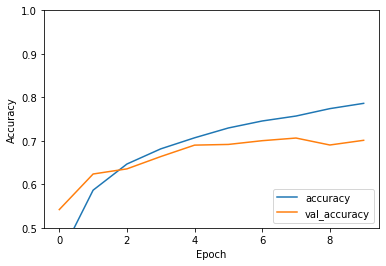

In [2]:
#Evaluating the model using the test dataset and measuring the accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

testLoss, testAccuracy = model.evaluate(testImages,  testLables, verbose=2)

print("Test Loss: ", testLoss)
print("Test Accuracy: ", testAccuracy)

'''  Command line results attatched in results.txt file. 
 Had a lot of fun doing this and learnt alot. Let me know the things I could improve upon.
 Excited to hopefully join the team and learn more. :)  '''